# Camera calibration
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YoniChechik/AI_is_Math/blob/master/c_07_camera_calibration/multi_plane_calib.ipynb)



camera calibration for distorted images with chess board samples
reads distorted images, calculates the calibration and write undistorted images

original code is from opencv tutorials:

https://github.com/opencv/opencv/blob/master/samples/python/calibrate.py

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html

read more about the functions here:

https://docs.opencv2.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

a reference calibration plane for printing can be copied from here:

https://stackoverflow.com/questions/25233198/opencv-2-4-9-for-python-cannot-find-chessboard-camera-calibration-tutorial 



In [1]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess 
    subprocess.call('apt-get install subversion'.split())
    subprocess.call('svn export https://github.com/YoniChechik/AI_is_Math/trunk/c_07_camera_calibration/images'.split())




In [2]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt


In [3]:
square_size=2.88
img_mask='./images/*.jpeg'
pattern_size = (9, 6)

figsize = (20,20)


In [4]:

img_names = glob(img_mask)
num_images = len(img_names)

pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

obj_points = []
img_points = []
h, w = cv2.imread(img_names[0]).shape[:2]



## Step 1: find all corners in calibration plane


processing ./images\1.jpeg... 
           ./images\1.jpeg... OK
processing ./images\10.jpeg... 
           ./images\10.jpeg... OK
processing ./images\11.jpeg... 
           ./images\11.jpeg... OK
processing ./images\12.jpeg... 
           ./images\12.jpeg... OK
processing ./images\13.jpeg... 
           ./images\13.jpeg... OK
processing ./images\14.jpeg... 
           ./images\14.jpeg... OK
processing ./images\15.jpeg... 
           ./images\15.jpeg... OK
processing ./images\16.jpeg... 
           ./images\16.jpeg... OK
processing ./images\17.jpeg... 
           ./images\17.jpeg... OK
processing ./images\2.jpeg... 
           ./images\2.jpeg... OK
processing ./images\3.jpeg... 
           ./images\3.jpeg... OK
processing ./images\4.jpeg... 
           ./images\4.jpeg... OK
processing ./images\5.jpeg... 
           ./images\5.jpeg... OK
processing ./images\6.jpeg... 
           ./images\6.jpeg... OK
processing ./images\7.jpeg... 
           ./images\7.jpeg... OK
processing ./images\8.jp

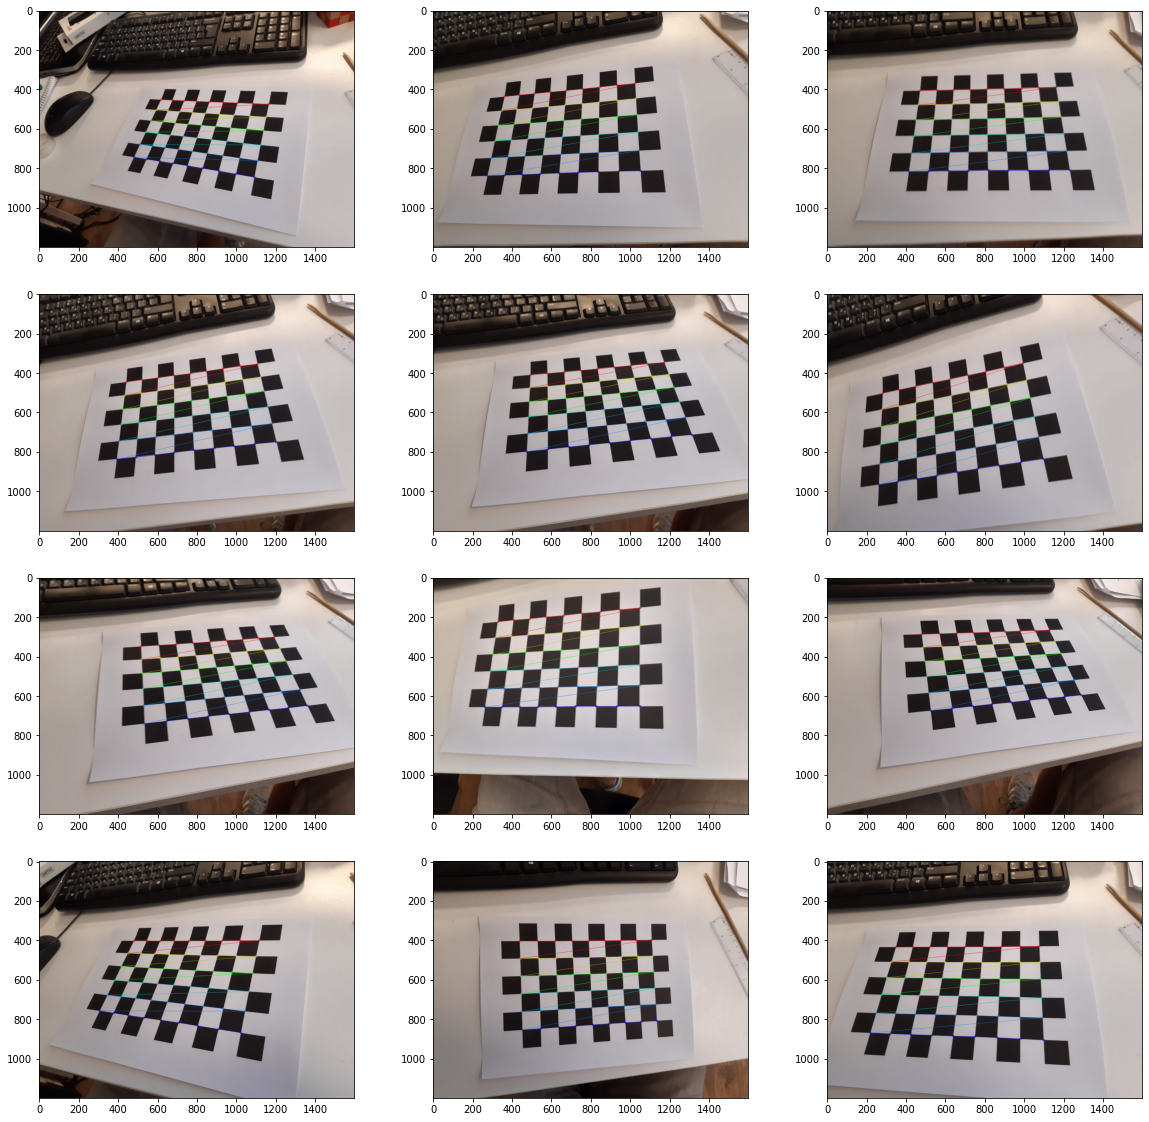

In [5]:
plt.figure(figsize=figsize)

for i,fn in enumerate(img_names):
    print('processing %s... ' % fn)
    imgBGR = cv2.imread(fn)

    if imgBGR is None:
        print("Failed to load", fn)
        continue

    imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(imgRGB,cv2.COLOR_RGB2GRAY)

    assert w == img.shape[1] and h == img.shape[0], ("size: %d x %d ... " % (img.shape[1], img.shape[0]))
    found, corners = cv2.findChessboardCorners(img, pattern_size)
    # # if you want to better improve the accuracy... cv2.findChessboardCorners already uses cv2.cornerSubPix 
    # if found:
    #     term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
    #     cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    if not found:
        print('chessboard not found')
        continue

    if i<12:
        img_w_corners = cv2.drawChessboardCorners(imgRGB, pattern_size, corners, found)
        plt.subplot(4,3,i+1)
        plt.imshow(img_w_corners)



    print('           %s... OK' % fn)
    img_points.append(corners.reshape(-1, 2))
    obj_points.append(pattern_points)


plt.show()



## Step 2: get camera intrinsics + distortion coeffs 
also get extrinsic rotation and translation vectors per image. Rotation vector is another representation for a full R matrix 
more on it here: https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula 


In [6]:
# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())




RMS: 0.9717982774285921
camera matrix:
 [[1.23559063e+03 0.00000000e+00 7.90654119e+02]
 [0.00000000e+00 1.23783760e+03 6.16444448e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [ 2.16337296e-01 -8.82451301e-01  1.04170317e-04  1.39993252e-03
  1.09531234e+00]


## Build undistorted images


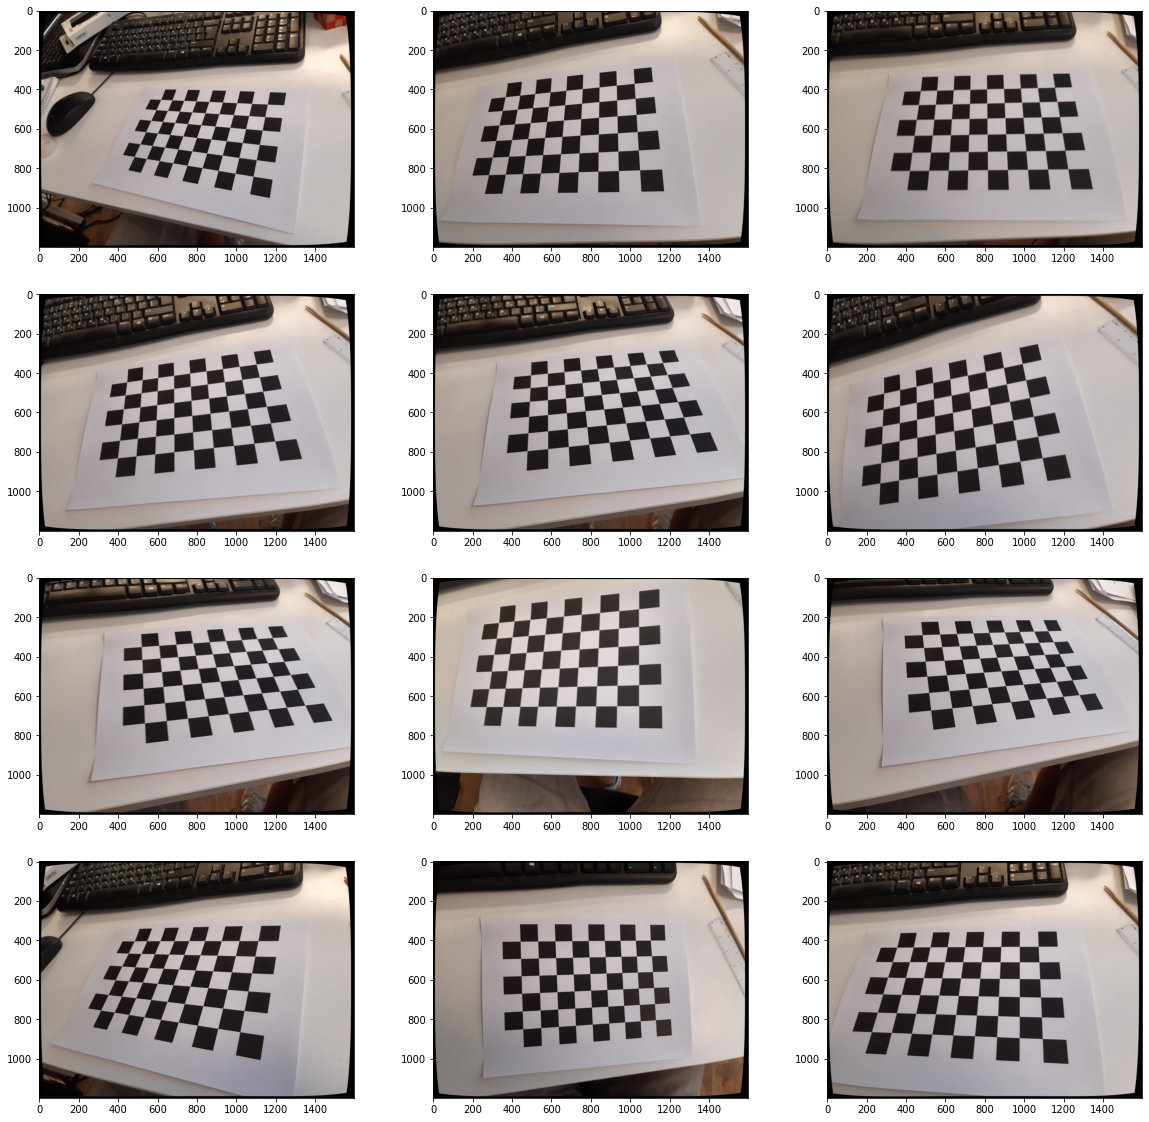

Done


In [7]:
# undistort the image with the calibration
plt.figure(figsize=figsize)
for i,fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)

    if i<12:
        plt.subplot(4,3,i+1)
        plt.imshow(dst)

plt.show()
print('Done')



## Example for full projection from 3D to 2D of a cube


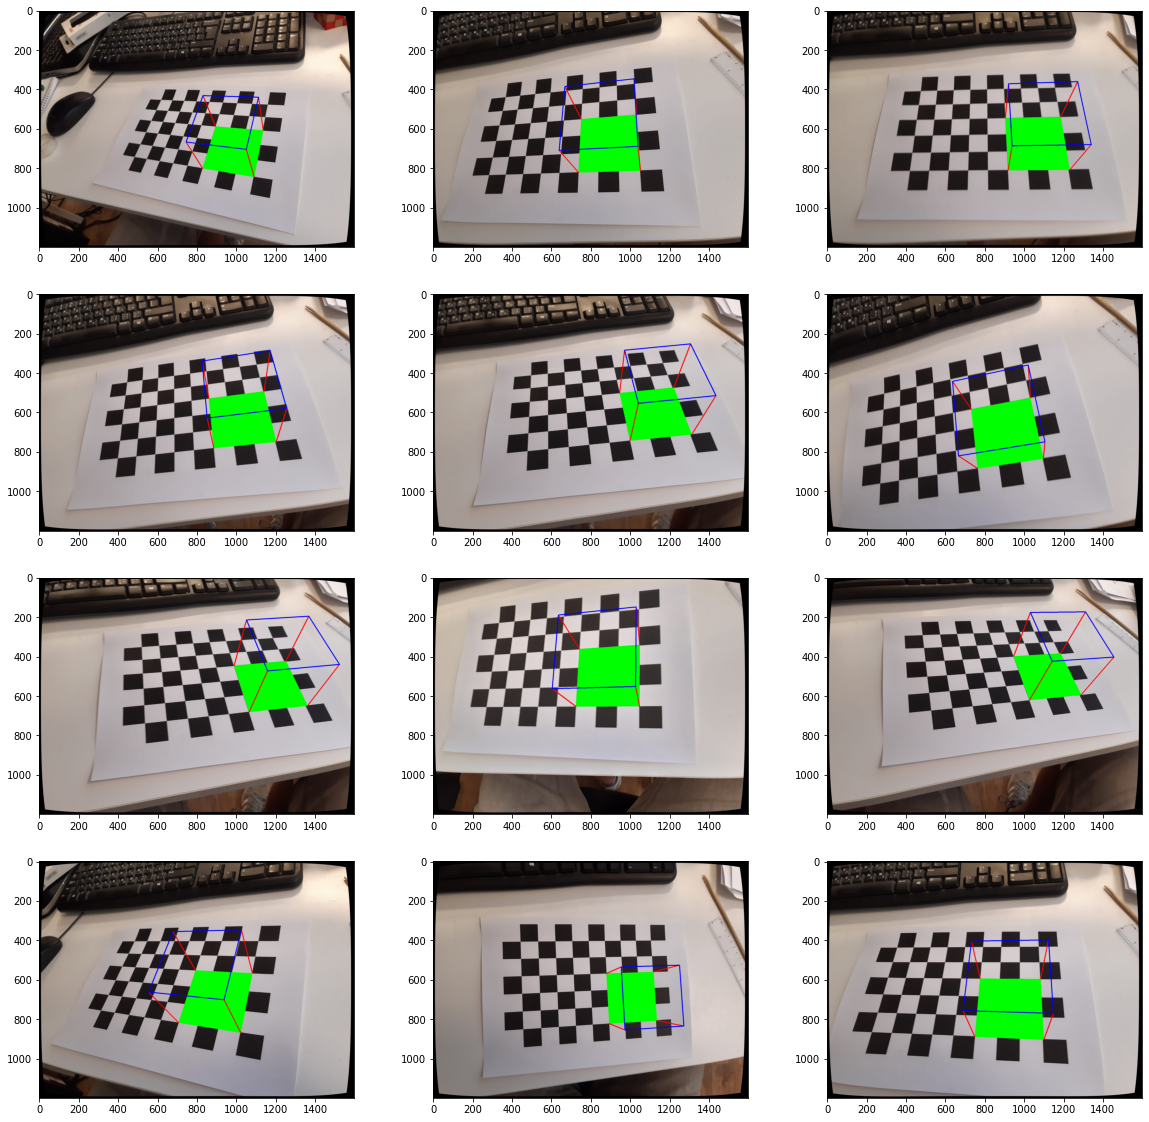

In [8]:
objectPoints = 3*square_size*np.array([[0,0,0], [0,1,0], [1,1,0], [1,0,0],[0,0,-1],[0,1,-1],[1,1,-1],[1,0,-1]])

def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-1)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img


plt.figure(figsize=figsize)
for i,fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)
    
    imgpts = cv2.projectPoints(	objectPoints, _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)[0]
    drawn_image = draw(dst, imgpts)

    if i<12:
        plt.subplot(4,3,i+1)
        plt.imshow(drawn_image)

plt.show()
